In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from google.colab import files
 
uploaded = files.upload()

Saving df_final_rolling_ready_50_with_bookodds.csv to df_final_rolling_ready_50_with_bookodds.csv


In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [68]:
df = pd.read_csv('df_final_rolling_ready_50_with_bookodds.csv')
# nb_rows_train = int(round(len(df)*0.7,0))
# df['best_odd_player_1'] = df[["player_1_B365", "player_1_PS"]].max(axis=1)
# df['best_odd_player_2'] = df[["player_2_B365", "player_2_PS"]].max(axis=1)
# df_info_streamlit = pd.concat([df['year'],df['month'],df['day'], df['Round'],df['player_1_name'],df['player_2_name'],df['best_odd_player_1'],df['best_odd_player_2']],axis = 1)
# df_info_streamlit = df_info_streamlit[nb_rows_train:]
# df_info_streamlit = df_info_streamlit.reset_index()
# df_info_streamlit.drop(['index'],axis = 1, inplace = True)
# df_info_streamlit.head()
# df_info_streamlit.to_csv('df_matchs_streamlit.csv') 
# files.download("df_matchs_streamlit.csv")

,year,month,day,Round,player_1_name,player_2_name,best_odd_player_1,best_odd_player_2
0,2015,2,24,1st Round,Austin Krajicek,Santiago Giraldo,2.31,1.68
1,2015,2,24,1st Round,Andreas Haider-Maurer,Robin Haase,2.00,1.97
2,2015,2,24,1st Round,Filip Krajinovic,Grigor Dimitrov,10.91,1.07
3,2015,2,24,1st Round,Jeremy Chardy,Tomas Berdych,8.44,1.09
4,2015,2,24,1st Round,Simone Bolelli,Lucas Pouille,1.45,2.94


In [69]:

# Encodage
le = LabelEncoder()
le.fit(pd.concat([df['player_1_name'], df['player_2_name']], axis=0))
df['player_1_name_encoded'] = le.transform(df['player_1_name'])
df['player_2_name_encoded'] = le.transform(df['player_2_name'])

# Suppression player_1_name & player_2
df.drop(['player_1_name', 'player_2_name'], axis=1, inplace=True)

# Dichotomisation
df = pd.get_dummies(df)

# Split
nb_rows_train = int(round(len(df)*0.7,0))
X_train = df.drop('player_1_win', axis=1)[:nb_rows_train]
y_train = df['player_1_win'][:nb_rows_train]
X_test = df.drop('player_1_win', axis=1)[nb_rows_train:]
y_test = df['player_1_win'][nb_rows_train:]

# # Paramétrisation LogReg & GridSearch
# clf = RandomForestClassifier()
# tscv = TimeSeriesSplit(n_splits=5)
# param_grid = {'n_estimators' : [50,75,100,200], 'criterion' : ['entropy','gini'], 'max_depth' : [3,4,5,6],'random_state' : [10]}
# gridcv = GridSearchCV(clf, param_grid=param_grid, cv = tscv, scoring='accuracy')

# # # Entrainement du modèle
# gridcv.fit(X_train, y_train)

# print(f"Estimateur : {gridcv.best_estimator_}")
# print(f"Score sur le jeu d'entraînement : {gridcv.best_score_}")

# # Prédiction du modèle
# print(f"Score sur l'ensemble test : {gridcv.score(X_test, y_test)}")

# print(f"Paramètres : {gridcv.best_params_}")

In [70]:
from joblib import dump, load

# dump(gridcv, 'Best_RF.joblib')
# RF = load('Best_RF.joblib')

In [71]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:

#Stratégie de paris RANDOM FOREST

loaded_model = load('Best_RF (1).joblib')

#Création d'un DataFrame comparant les probabilités estimées par le classifieur vs les bookmakers

df_probas = pd.concat([df['player_1_B365'][nb_rows_train:],df['player_1_PS'][nb_rows_train:],df['player_2_B365'][nb_rows_train:],df['player_2_PS'][nb_rows_train:]],axis = 1)
y_proba = loaded_model.predict_proba(X_test)
df_probas['best_odd_player_1'] = df_probas[["player_1_B365", "player_1_PS"]].max(axis=1)
df_probas['best_odd_player_2'] = df_probas[["player_2_B365", "player_2_PS"]].max(axis=1)
df_probas['proba_model_player_1'] = y_proba[:,1]
df_probas['proba_model_player_2'] = y_proba[:,0]

df_probas['EV_player_1'] = df_probas['best_odd_player_1']*df_probas['proba_model_player_1']
df_probas['EV_player_2'] = df_probas['best_odd_player_2']*df_probas['proba_model_player_2']

df_probas['player_1_win'] = y_test

#Création d'un DataFrame gardant uniquement les infos des paris estimés comme rentables (ici de minimum 15%) par l'algorithme

EV_needed = 1
# cote_min_opt = 2.15
# cote_max_opt = 31.5
cote_min = 2.15
cote_max = 6.95

value_bet_1 = df_probas[df_probas['EV_player_1'] > EV_needed][df_probas['best_odd_player_1'] < cote_max][df_probas['best_odd_player_1'] > cote_min]
value_bet_1['money_won'] = value_bet_1['best_odd_player_1']*value_bet_1['player_1_win'] - 1

value_bet_2 = df_probas[df_probas['EV_player_2'] > EV_needed][df_probas['best_odd_player_2'] < cote_max][df_probas['best_odd_player_2'] > cote_min]
value_bet_2['player_2_win'] = value_bet_2['player_1_win']
value_bet_2['player_2_win'].replace([0,1],[1,0],inplace = True)
value_bet_2['money_won'] = value_bet_2['best_odd_player_2']*value_bet_2['player_2_win'] - 1
value_bets = pd.concat([value_bet_1,value_bet_2])

value_bets.drop(['player_1_B365','player_1_PS','player_2_B365','player_2_PS'],axis = 1,inplace = True)

print(f"En pariant 1€ sur toutes les côtes que le modèle considère comme rentables sur l'ensemble test, nous gagnons au total {round(value_bets['money_won'].sum(),2)}€")

En pariant 1€ sur toutes les côtes que le modèle considère comme rentables sur l'ensemble test, nous gagnons au total 227.26€


<ipython-input-71-0d7e1670c629>:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  value_bet_1 = df_probas[df_probas['EV_player_1'] > EV_needed][df_probas['best_odd_player_1'] < cote_max][df_probas['best_odd_player_1'] > cote_min]
<ipython-input-71-0d7e1670c629>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  value_bet_2 = df_probas[df_probas['EV_player_2'] > EV_needed][df_probas['best_odd_player_2'] < cote_max][df_probas['best_odd_player_2'] > cote_min]


In [ ]:
print(f"En pariant 1€ sur toutes les côtes que le modèle considère comme rentables sur l'ensemble test, nous gagnons au total {round(value_bets['money_won'].sum(),2)}€")

En pariant 1€ sur toutes les côtes que le modèle considère comme rentables sur l'ensemble test, nous gagnons au total 107.02€


count    4570.000000
mean        0.049729
std         1.667138
min        -1.000000
25%        -1.000000
50%        -1.000000
75%         1.500000
max         5.920000
Name: money_won, dtype: float64


Text(0.5, 1.0, 'Distribution des probabilités Random Forest')

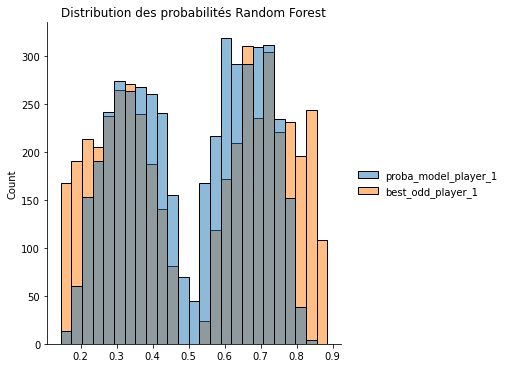

In [ ]:
print(value_bets['money_won'].describe())

sns.displot((value_bets['proba_model_player_1'],1/value_bets['best_odd_player_1']),kind = 'hist',bins = 25, label = ['Probas RF','Probas Bookmakers'])
plt.title('Distribution des probabilités Random Forest')

In [ ]:

#Stratégie de paris REGRESSION LOGISTIQUE

loaded_model = load('Best_LR.joblib')

#Création d'un DataFrame comparant les probabilités estimées par le classifieur vs les bookmakers

df_probas = pd.concat([df['player_1_B365'][nb_rows_train:],df['player_1_PS'][nb_rows_train:],df['player_2_B365'][nb_rows_train:],df['player_2_PS'][nb_rows_train:]],axis = 1)
y_proba = loaded_model.predict_proba(X_test_scaled)
df_probas['best_odd_player_1'] = df_probas[["player_1_B365", "player_1_PS"]].max(axis=1)
df_probas['best_odd_player_2'] = df_probas[["player_2_B365", "player_2_PS"]].max(axis=1)
df_probas['proba_model_player_1'] = y_proba[:,1]
df_probas['proba_model_player_2'] = y_proba[:,0]

df_probas['EV_player_1'] = df_probas['best_odd_player_1']*df_probas['proba_model_player_1']
df_probas['EV_player_2'] = df_probas['best_odd_player_2']*df_probas['proba_model_player_2']

df_probas['player_1_win'] = y_test

#Création d'un DataFrame gardant uniquement les infos des paris estimés comme rentables (ici de minimum 15%) par l'algorithme

EV_needed = 1
# cote_min_opt = 2.05
# cote_max_opt = 6.95
cote_min = 2.05
cote_max = 6.93

value_bet_1 = df_probas[df_probas['EV_player_1'] > EV_needed][df_probas['best_odd_player_1'] < cote_max][df_probas['best_odd_player_1'] > cote_min]
value_bet_1['money_won'] = value_bet_1['best_odd_player_1']*value_bet_1['player_1_win'] - 1

value_bet_2 = df_probas[df_probas['EV_player_2'] > EV_needed][df_probas['best_odd_player_2'] < cote_max][df_probas['best_odd_player_2'] > cote_min]
value_bet_2['player_2_win'] = value_bet_2['player_1_win']
value_bet_2['player_2_win'].replace([0,1],[1,0],inplace = True)
value_bet_2['money_won'] = value_bet_2['best_odd_player_2']*value_bet_2['player_2_win'] - 1
value_bets = pd.concat([value_bet_1,value_bet_2])

value_bets.drop(['player_1_B365','player_1_PS','player_2_B365','player_2_PS'],axis = 1,inplace = True)

print(f"En pariant 1€ sur toutes les côtes que le modèle considère comme rentables sur l'ensemble test, nous gagnons au total {round(value_bets['money_won'].sum(),2)}€")

En pariant 1€ sur toutes les côtes que le modèle considère comme rentables sur l'ensemble test, nous gagnons au total 158.62€


<ipython-input-372-4dc9459a4aa1>:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  value_bet_1 = df_probas[df_probas['EV_player_1'] > EV_needed][df_probas['best_odd_player_1'] < cote_max][df_probas['best_odd_player_1'] > cote_min]
<ipython-input-372-4dc9459a4aa1>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  value_bet_2 = df_probas[df_probas['EV_player_2'] > EV_needed][df_probas['best_odd_player_2'] < cote_max][df_probas['best_odd_player_2'] > cote_min]


count    6662.000000
mean        0.023810
std         1.537644
min        -1.000000
25%        -1.000000
50%        -1.000000
75%         1.370000
max         5.920000
Name: money_won, dtype: float64


Text(0.5, 1.0, 'Distribution des probabilités Régression Logistique')

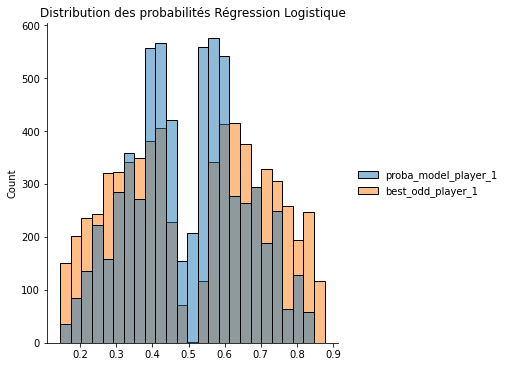

In [ ]:
print(value_bets['money_won'].describe())

sns.displot((value_bets['proba_model_player_1'],1/value_bets['best_odd_player_1']),kind = 'hist',bins = 25, label = ['Probas RF','Probas Bookmakers'])
plt.title('Distribution des probabilités Régression Logistique')

In [ ]:

#Stratégie de paris GRADIENT BOOSTING : NON RENTABLE

loaded_model = load('Best_GBC.joblib')

#Création d'un DataFrame comparant les probabilités estimées par le classifieur vs les bookmakers

df_probas = pd.concat([df['player_1_B365'][nb_rows_train:],df['player_1_PS'][nb_rows_train:],df['player_2_B365'][nb_rows_train:],df['player_2_PS'][nb_rows_train:]],axis = 1)
y_proba = loaded_model.predict_proba(X_test_scaled)
df_probas['best_odd_player_1'] = df_probas[["player_1_B365", "player_1_PS"]].max(axis=1)
df_probas['best_odd_player_2'] = df_probas[["player_2_B365", "player_2_PS"]].max(axis=1)
df_probas['proba_model_player_1'] = y_proba[:,1]
df_probas['proba_model_player_2'] = y_proba[:,0]

df_probas['EV_player_1'] = df_probas['best_odd_player_1']*df_probas['proba_model_player_1']
df_probas['EV_player_2'] = df_probas['best_odd_player_2']*df_probas['proba_model_player_2']

df_probas['player_1_win'] = y_test

#Création d'un DataFrame gardant uniquement les infos des paris estimés comme rentables (ici de minimum 15%) par l'algorithme

EV_needed = 1
# cote_min_opt = 1
# cote_max_opt = 10000
cote_min = 1
cote_max = 100000

value_bet_1 = df_probas[df_probas['EV_player_1'] > EV_needed][df_probas['best_odd_player_1'] < cote_max][df_probas['best_odd_player_1'] > cote_min]
value_bet_1['money_won'] = value_bet_1['best_odd_player_1']*value_bet_1['player_1_win'] - 1

value_bet_2 = df_probas[df_probas['EV_player_2'] > EV_needed][df_probas['best_odd_player_2'] < cote_max][df_probas['best_odd_player_2'] > cote_min]
value_bet_2['player_2_win'] = value_bet_2['player_1_win']
value_bet_2['player_2_win'].replace([0,1],[1,0],inplace = True)
value_bet_2['money_won'] = value_bet_2['best_odd_player_2']*value_bet_2['player_2_win'] - 1
value_bets = pd.concat([value_bet_1,value_bet_2])

value_bets.drop(['player_1_B365','player_1_PS','player_2_B365','player_2_PS'],axis = 1,inplace = True)

print(f"En pariant 1€ sur toutes les côtes que le modèle considère comme rentables sur l'ensemble test, nous gagnons au total {round(value_bets['money_won'].sum(),2)}€")

En pariant 1€ sur toutes les côtes que le modèle considère comme rentables sur l'ensemble test, nous gagnons au total -41.91€


<ipython-input-9-7cd6589f0c61>:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  value_bet_1 = df_probas[df_probas['EV_player_1'] > EV_needed][df_probas['best_odd_player_1'] < cote_max][df_probas['best_odd_player_1'] > cote_min]
<ipython-input-9-7cd6589f0c61>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  value_bet_2 = df_probas[df_probas['EV_player_2'] > EV_needed][df_probas['best_odd_player_2'] < cote_max][df_probas['best_odd_player_2'] > cote_min]


count    874.000000
mean      -0.047952
std        3.293711
min       -1.000000
25%       -1.000000
50%       -1.000000
75%       -1.000000
max       30.300000
Name: money_won, dtype: float64


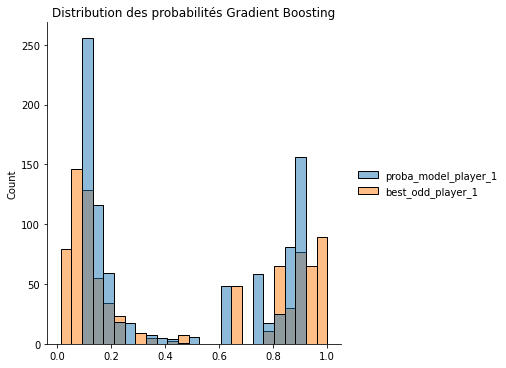

In [ ]:
print(value_bets['money_won'].describe())

sns.displot((value_bets['proba_model_player_1'],1/value_bets['best_odd_player_1']),kind = 'hist',bins = 25, label = ['Probas RF','Probas Bookmakers'])
plt.title('Distribution des probabilités Gradient Boosting');

In [ ]:

#Stratégie de paris KNN

loaded_model = load('Best_KNN.joblib')

# Création d'un DataFrame comparant les probabilités estimées par le classifieur vs les bookmakers
'''
df_probas = pd.concat([df['player_1_B365'][nb_rows_train:],df['player_1_PS'][nb_rows_train:],df['player_2_B365'][nb_rows_train:],df['player_2_PS'][nb_rows_train:]],axis = 1)
y_proba = loaded_model.predict_proba(X_test_scaled)
df_probas['best_odd_player_1'] = df_probas[["player_1_B365", "player_1_PS"]].max(axis=1)
df_probas['best_odd_player_2'] = df_probas[["player_2_B365", "player_2_PS"]].max(axis=1)
df_probas['proba_model_player_1'] = y_proba[:,1]
df_probas['proba_model_player_2'] = y_proba[:,0]

df_probas['EV_player_1'] = df_probas['best_odd_player_1']*df_probas['proba_model_player_1']
df_probas['EV_player_2'] = df_probas['best_odd_player_2']*df_probas['proba_model_player_2']

df_probas['player_1_win'] = y_test
'''
# Création d'un DataFrame gardant uniquement les infos des paris estimés comme rentables (ici de minimum 15%) par l'algorithme

EV_needed = 1
# cote_min_opt = 2.10
# cote_max_opt = 6.93
cote_min = 2.1
cote_max = 6.93

value_bet_1 = df_probas[df_probas['EV_player_1'] > EV_needed][df_probas['best_odd_player_1'] < cote_max][df_probas['best_odd_player_1'] > cote_min]
value_bet_1['money_won'] = value_bet_1['best_odd_player_1']*value_bet_1['player_1_win'] - 1

value_bet_2 = df_probas[df_probas['EV_player_2'] > EV_needed][df_probas['best_odd_player_2'] < cote_max][df_probas['best_odd_player_2'] > cote_min]
value_bet_2['player_2_win'] = value_bet_2['player_1_win']
value_bet_2['player_2_win'].replace([0,1],[1,0],inplace = True)
value_bet_2['money_won'] = value_bet_2['best_odd_player_2']*value_bet_2['player_2_win'] - 1
value_bets = pd.concat([value_bet_1,value_bet_2])

value_bets.drop(['player_1_B365','player_1_PS','player_2_B365','player_2_PS'],axis = 1,inplace = True)

print(f"En pariant 1€ sur toutes les côtes que le modèle considère comme rentables sur l'ensemble test, nous gagnons au total {round(value_bets['money_won'].sum(),2)}€")

En pariant 1€ sur toutes les côtes que le modèle considère comme rentables sur l'ensemble test, nous gagnons au total 214.63€


<ipython-input-33-ab00d607aa5d>:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  value_bet_1 = df_probas[df_probas['EV_player_1'] > EV_needed][df_probas['best_odd_player_1'] < cote_max][df_probas['best_odd_player_1'] > cote_min]
<ipython-input-33-ab00d607aa5d>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  value_bet_2 = df_probas[df_probas['EV_player_2'] > EV_needed][df_probas['best_odd_player_2'] < cote_max][df_probas['best_odd_player_2'] > cote_min]


count    6405.000000
mean        0.033510
std         1.571067
min        -1.000000
25%        -1.000000
50%        -1.000000
75%         1.370000
max         5.920000
Name: money_won, dtype: float64


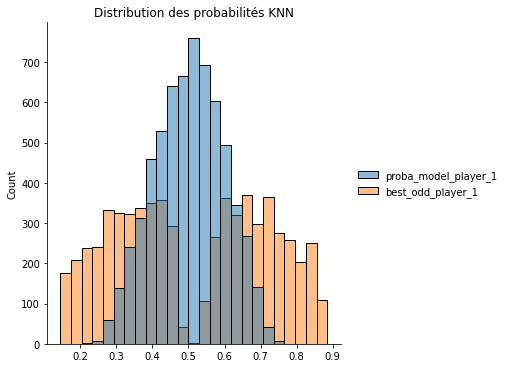

In [ ]:
print(value_bets['money_won'].describe())

sns.displot((value_bets['proba_model_player_1'],1/value_bets['best_odd_player_1']),kind = 'hist',bins = 25, label = ['Probas RF','Probas Bookmakers'])
plt.title('Distribution des probabilités KNN');

In [73]:
#Stratégie de paris Voting Classifier

loaded_model = load('Best_VC_LR_GBC (1).joblib')

# Création d'un DataFrame comparant les probabilités estimées par le classifieur vs les bookmakers

df_probas = pd.concat([df['player_1_B365'][nb_rows_train:],df['player_1_PS'][nb_rows_train:],df['player_2_B365'][nb_rows_train:],df['player_2_PS'][nb_rows_train:]],axis = 1)
y_proba = loaded_model.predict_proba(X_test_scaled)
df_probas['best_odd_player_1'] = df_probas[["player_1_B365", "player_1_PS"]].max(axis=1)
df_probas['best_odd_player_2'] = df_probas[["player_2_B365", "player_2_PS"]].max(axis=1)
df_probas['proba_model_player_1'] = y_proba[:,1]
df_probas['proba_model_player_2'] = y_proba[:,0]

df_probas['EV_player_1'] = df_probas['best_odd_player_1']*df_probas['proba_model_player_1']
df_probas['EV_player_2'] = df_probas['best_odd_player_2']*df_probas['proba_model_player_2']

df_probas['player_1_win'] = y_test

# Création d'un DataFrame gardant uniquement les infos des paris estimés comme rentables (ici de minimum 15%) par l'algorithme

EV_needed = 1
# cote_min_opt = 2.15
# cote_max_opt = 31.5
cote_min = 1
cote_max = 3001.5

value_bet_1 = df_probas[df_probas['EV_player_1'] > EV_needed][df_probas['best_odd_player_1'] < cote_max][df_probas['best_odd_player_1'] > cote_min]
value_bet_1['money_won'] = value_bet_1['best_odd_player_1']*value_bet_1['player_1_win'] - 1

value_bet_2 = df_probas[df_probas['EV_player_2'] > EV_needed][df_probas['best_odd_player_2'] < cote_max][df_probas['best_odd_player_2'] > cote_min]
value_bet_2['player_2_win'] = value_bet_2['player_1_win']
value_bet_2['player_2_win'].replace([0,1],[1,0],inplace = True)
value_bet_2['money_won'] = value_bet_2['best_odd_player_2']*value_bet_2['player_2_win'] - 1
value_bets = pd.concat([value_bet_1,value_bet_2])

value_bets.drop(['player_1_B365','player_1_PS','player_2_B365','player_2_PS'],axis = 1,inplace = True)

print(f"En pariant 1€ sur toutes les côtes que le modèle considère comme rentables sur l'ensemble test, nous gagnons au total {round(value_bets['money_won'].sum(),2)}€")

En pariant 1€ sur toutes les côtes que le modèle considère comme rentables sur l'ensemble test, nous gagnons au total 162.92€


<ipython-input-73-fd568cf9778e>:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  value_bet_1 = df_probas[df_probas['EV_player_1'] > EV_needed][df_probas['best_odd_player_1'] < cote_max][df_probas['best_odd_player_1'] > cote_min]
<ipython-input-73-fd568cf9778e>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  value_bet_2 = df_probas[df_probas['EV_player_2'] > EV_needed][df_probas['best_odd_player_2'] < cote_max][df_probas['best_odd_player_2'] > cote_min]


In [79]:
# df_probas.to_csv("df_probas_VC.csv")
# files.download("df_probas_VC.csv")

df_probas = df_probas.reset_index()
df_probas.drop(['index'],axis = 1, inplace = True)
df_probas.head()
df_probas.to_csv('df_probas_VC.csv') 
files.download("df_probas_VC.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [80]:
df_probas

,player_1_B365,player_1_PS,player_2_B365,player_2_PS,best_odd_player_1,best_odd_player_2,proba_model_player_1,proba_model_player_2,EV_player_1,EV_player_2,player_1_win
0,2.25,2.31,1.57,1.68,2.31,1.68,0.420521,0.579479,0.971403,0.973525,0
1,2.00,1.92,1.72,1.97,2.00,1.97,0.487652,0.512348,0.975304,1.009326,1
2,10.00,10.91,1.05,1.07,10.91,1.07,0.081191,0.918809,0.885792,0.983126,0
3,8.00,8.44,1.08,1.09,8.44,1.09,0.114650,0.885350,0.967648,0.965031,0
4,1.40,1.45,2.75,2.94,1.45,2.94,0.633204,0.366796,0.918146,1.078380,1
...,...,...,...,...,...,...,...,...,...,...,...
8595,2.00,2.20,1.80,1.76,2.20,1.80,0.457251,0.542749,1.005952,0.976948,1
8596,1.36,1.42,3.20,3.12,1.42,3.20,0.675216,0.324784,0.958807,1.039307,0
8597,3.50,3.75,1.30,1.33,3.75,1.33,0.293981,0.706019,1.102429,0.939005,1
8598,1.80,1.84,2.00,2.10,1.84,2.10,0.513181,0.486819,0.944254,1.022319,1


count    6309.000000
mean        0.034898
std         1.862764
min        -1.000000
25%        -1.000000
50%        -1.000000
75%         1.420000
max        30.300000
Name: money_won, dtype: float64


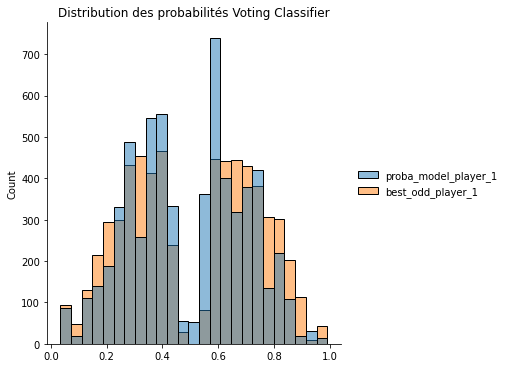

In [ ]:
print(value_bets['money_won'].describe())

sns.displot((value_bets['proba_model_player_1'],1/value_bets['best_odd_player_1']),kind = 'hist',bins = 25, label = ['Probas RF','Probas Bookmakers'])
plt.title('Distribution des probabilités Voting Classifier');

In [76]:
dump(value_bets,'value_bets.joblib')

FileNotFoundError: ignored

In [ ]:
print(f"Probabilité qu'un pari soit gagnant : {100-round(value_bets[value_bets['money_won'] < 0].shape[0]/value_bets.shape[0]*100,2)}%")
print(f"Probabilité qu'un pari soit perdant : {round(value_bets[value_bets['money_won'] < 0].shape[0]/value_bets.shape[0]*100,2)}%")
print(f"Risque de ruine")

Probabilité qu'un pari soit gagnant : 32.45%
Probabilité qu'un pari soit perdant : 67.55%


In [ ]:
value_bets[value_bets['money_won'] > 0].describe()

,best_odd_player_1,best_odd_player_2,proba_model_player_1,proba_model_player_2,EV_player_1,EV_player_2,player_1_win,money_won,player_2_win
count,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,1167.0
mean,2.387538,2.531051,0.506761,0.493239,0.996430,1.000526,0.480410,2.154461,1.0
std,1.687646,1.898620,0.172348,0.172348,0.071772,0.077071,0.499727,1.811738,0.0
min,1.010000,1.010000,0.052794,0.048169,0.811949,0.687933,0.000000,0.060000,1.0
25%,1.500000,1.530000,0.383083,0.390247,0.939785,0.944227,0.000000,1.370000,1.0
50%,1.830000,2.100000,0.516624,0.483376,0.978129,1.004120,0.000000,1.730000,1.0
75%,2.750000,2.800000,0.609753,0.616917,1.041102,1.051801,1.000000,2.450000,1.0
max,27.220000,31.300000,0.951831,0.947206,1.437049,1.507702,1.000000,30.300000,1.0


In [ ]:
#Stratégie de paris XG Boost

loaded_model = load('Best_XGBOOST.joblib')

# Création d'un DataFrame comparant les probabilités estimées par le classifieur vs les bookmakers

df_probas = pd.concat([df['player_1_B365'][nb_rows_train:],df['player_1_PS'][nb_rows_train:],df['player_2_B365'][nb_rows_train:],df['player_2_PS'][nb_rows_train:]],axis = 1)
y_proba = loaded_model.predict_proba(X_test_scaled)
df_probas['best_odd_player_1'] = df_probas[["player_1_B365", "player_1_PS"]].max(axis=1)
df_probas['best_odd_player_2'] = df_probas[["player_2_B365", "player_2_PS"]].max(axis=1)
df_probas['proba_model_player_1'] = y_proba[:,1]
df_probas['proba_model_player_2'] = y_proba[:,0]

df_probas['EV_player_1'] = df_probas['best_odd_player_1']*df_probas['proba_model_player_1']
df_probas['EV_player_2'] = df_probas['best_odd_player_2']*df_probas['proba_model_player_2']

df_probas['player_1_win'] = y_test

# Création d'un DataFrame gardant uniquement les infos des paris estimés comme rentables (ici de minimum 15%) par l'algorithme

EV_needed = 1
# cote_min_opt = 2.15
# cote_max_opt = 31.5
cote_min = 2.15
cote_max = 31.5

value_bet_1 = df_probas[df_probas['EV_player_1'] > EV_needed][df_probas['best_odd_player_1'] < cote_max][df_probas['best_odd_player_1'] > cote_min]
value_bet_1['money_won'] = value_bet_1['best_odd_player_1']*value_bet_1['player_1_win'] - 1

value_bet_2 = df_probas[df_probas['EV_player_2'] > EV_needed][df_probas['best_odd_player_2'] < cote_max][df_probas['best_odd_player_2'] > cote_min]
value_bet_2['player_2_win'] = value_bet_2['player_1_win']
value_bet_2['player_2_win'].replace([0,1],[1,0],inplace = True)
value_bet_2['money_won'] = value_bet_2['best_odd_player_2']*value_bet_2['player_2_win'] - 1
value_bets = pd.concat([value_bet_1,value_bet_2])

value_bets.drop(['player_1_B365','player_1_PS','player_2_B365','player_2_PS'],axis = 1,inplace = True)

print(f"En pariant 1€ sur toutes les côtes que le modèle considère comme rentables sur l'ensemble test, nous gagnons au total {round(value_bets['money_won'].sum(),2)}€")

AttributeError: ignored